In [7]:

from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.config_tickers import TEST_TICKER

from online_algos import OLMAR

import pandas as pd
import matplotlib.pyplot as plt

TEST_START_DATE = '2022-01-01'
TEST_END_DATE = '2024-10-01'

ensemble_results_file = 'result.csv'

# PLOT_DATES_TEST_START = '2022-01-03'
# PLOT_DATES_TEST_END = '2022-12-30'

# ensemble_results_file = 'result2022.csv'


# value_to_remove = "DOW"
# # # Create a new list without the specified string
# DOW_30_TICKER = [x for x in DOW_30_TICKER if x != value_to_remove]


# test = [
# "AXP",
#     "AMGN",
#     "AAPL",
#     "BA",
#     "CAT"]


df = YahooDownloader(start_date = TEST_START_DATE,
                     end_date = TEST_END_DATE,
                     ticker_list = TEST_TICKER).fetch_data()


print(df.head())

# Count rows with any null values
null_rows_count = df.isnull().any(axis=1).sum()

print(f"Number of rows containing null values: {null_rows_count}")


print("Check for no-nulls")
print(df.notnull().all().all())

assert df.notnull().all().all()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (2756, 8)
         date        open        high         low       close     volume  \
0  2022-01-03  177.830002  182.880005  177.710007  179.273621  104487900   
1  2022-01-03  223.630005  226.970001  222.029999  207.807159    2742800   
2  2022-01-03  164.509995  168.399994  164.399994  161.699921    3236400   
3  2022-01-03  204.000000  210.550003  203.339996  207.860001    9060200   
4  2022-01-04  182.630005  182.940002  179.119995  176.998306   99310400   

    tic  day  
0  AAPL    0  
1  AMGN    0  
2   AXP    0  
3    BA    0  
4  AAPL    1  
Number of rows containing null values: 0
Check for no-nulls
True


date       object
open      float64
high      float64
low       float64
close     float64
volume      int64
tic        object
day         int32
dtype: object
            date        open        high         low       close     volume  \
0     2022-01-03  177.830002  182.880005  177.710007  179.273621  104487900   
1     2022-01-03  223.630005  226.970001  222.029999  207.807159    2742800   
2     2022-01-03  164.509995  168.399994  164.399994  161.699921    3236400   
3     2022-01-03  204.000000  210.550003  203.339996  207.860001    9060200   
4     2022-01-04  182.630005  182.940002  179.119995  176.998306   99310400   
...          ...         ...         ...         ...         ...        ...   
2751  2024-09-27  155.369995  157.330002  154.389999  156.320007    7637000   
2752  2024-09-30  230.039993  233.000000  229.649994  233.000000   54541900   
2753  2024-09-30  321.320007  323.230011  318.790009  322.209991    1966900   
2754  2024-09-30  270.100006  271.480011  267.290009

<Axes: xlabel='date'>

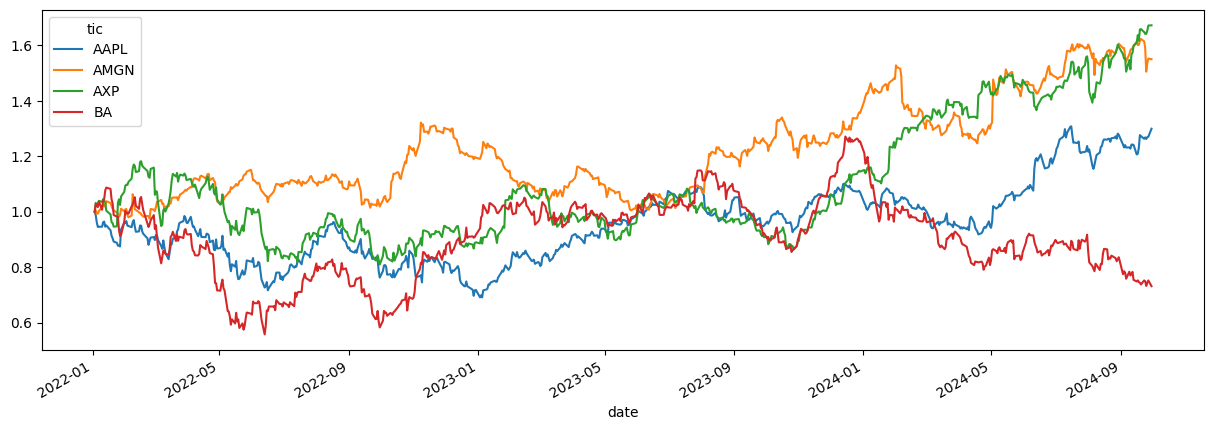

In [8]:
df = pd.DataFrame(df)

print(df.dtypes)
print(df)

# Pivot the DataFrame
pivot_df = df.pivot(index='date', columns='tic', values='close')

print(pivot_df)

pivot_df.index = pd.to_datetime(pivot_df.index)

(pivot_df / pivot_df.iloc[0,:]).plot()


Final Portfolio:
Shares: AAPL    2069.0
AMGN    1311.0
AXP     1858.0
BA      2595.0
dtype: float64
Total of each: AAPL         482077.0
AMGN    422417.298798
AXP      502576.35553
BA      394543.782578
dtype: object
Cash: 2085.65
Transaction fees: 11570.266839946747
Final Net Worth: 1803700.0911655768


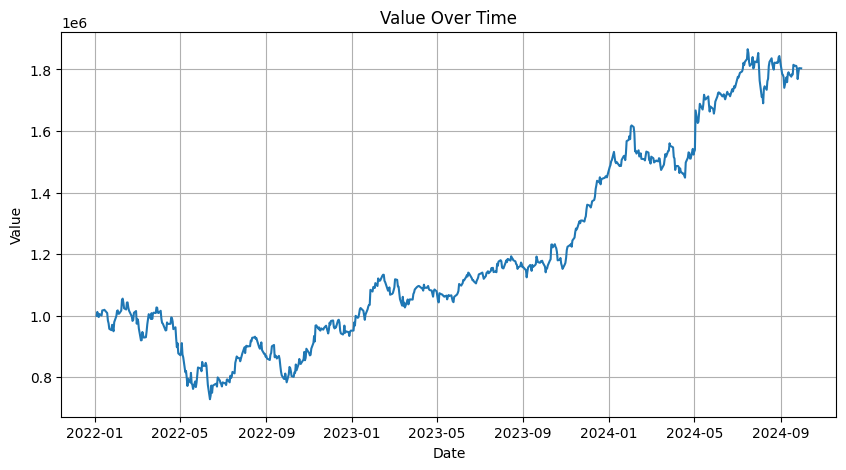

In [9]:
import numpy as np
import pandas as pd

transaction_fees=[]

def calculate_sma(prices, window):
    return prices.rolling(window=window).mean()

def rebalance_portfolio_olmar(cash, shares, prices, window=10, eps=10):
    # Calculate Moving Averages
    sma = calculate_sma(prices, window)
    
    # Calculate price deviation
    deviation = prices.iloc[-1] / sma.iloc[-1] - 1
    
    # Update target weights based on OLMAR algorithm
    excess_return = eps - deviation.mean()
    weights = np.maximum(0, deviation * excess_return)
    weights = weights / weights.sum()  # Normalize the weights

    if(weights.isnull().values.any()):
        # Default to uniform weights if no weights are calculated yet
        weights = (np.ones(len(prices.iloc[-1]))) / (len(prices.iloc[-1]))

    remaining_cash = cash
    
    # Available amount for purchases of each stock, must factor in the transaction cost
    current_wealth = (np.sum(prices.iloc[-1] * shares) + cash) / (1 + transaction_cost)

    target_values = weights * current_wealth
    target_shares = target_values // (prices.iloc[-1])
    
    shares_to_change = target_shares - shares

    sell_shares = np.where(shares_to_change < 0, -shares_to_change, 0)
    buy_shares = np.where(shares_to_change > 0, shares_to_change, 0)
    sale_amount = (np.sum(sell_shares * prices.iloc[-1]) + np.sum(buy_shares * prices.iloc[-1]))
    transaction_fee = (np.sum(sell_shares * prices.iloc[-1]) + np.sum(buy_shares * prices.iloc[-1])) * transaction_cost

    # Test a shrinkage factor
    pending_transaction = cash + np.sum(sell_shares * prices.iloc[-1]) - np.sum(buy_shares * prices.iloc[-1]) - transaction_fee

    # We are about to go negative on cash, need to use the shrink factor
    if (pending_transaction < 0):
        shrink_factor = (np.sum(prices.iloc[-1] * shares) + cash) / ((1 + transaction_cost) * sale_amount )
        shares_to_change = np.floor(shares_to_change * shrink_factor)

    # Readjusted to the shrink factor if needed
    sell_shares = np.where(shares_to_change < 0, -shares_to_change, 0)
    buy_shares = np.where(shares_to_change > 0, shares_to_change, 0)
    sale_amount = (np.sum(sell_shares * prices.iloc[-1]) + np.sum(buy_shares * prices.iloc[-1]))
    transaction_fee = (np.sum(sell_shares * prices.iloc[-1]) + np.sum(buy_shares * prices.iloc[-1])) * transaction_cost
    
    cash += np.sum(sell_shares * prices.iloc[-1])
    cash -= np.sum(buy_shares * prices.iloc[-1])

    shares = shares + shares_to_change
    remaining_cash = cash - transaction_fee

    transaction_fees.append(transaction_fee)

    assert remaining_cash >= 0, "Cash went negative"
    
    return shares, remaining_cash, weights


transaction_cost = 0.001

new_column_names = ['Date'] + [f'{col}' for col in pivot_df.columns]

# Convert to the desired format
X = pivot_df.reset_index()
X.columns = new_column_names

# Initialize to uniform shares
initial_cash = 1000000
initial_shares = np.ones(len(X.columns) - 1) / (len(X.columns) - 1)
net_worth = []

portfolio_shares = initial_shares
portfolio_cash = initial_cash

rebalance_iter = 50
rebalance_i = rebalance_iter

# Rebalance at each step
for idx, row in X.iterrows():
    price_per_share = row[1:].values
    
    # Reset the index as needed
    if (rebalance_i % rebalance_iter == 0):
        portfolio_shares, portfolio_cash, target_weights = rebalance_portfolio_olmar(
        portfolio_cash, 
        portfolio_shares, 
        X.set_index('Date').iloc[:idx+1], 
        window=5, 
        eps=10)

        rebalance_i = 0
    rebalance_i += 1
    
    asset_wealth = np.sum(portfolio_shares * price_per_share)
    net_worth.append(asset_wealth + portfolio_cash)

print("\nFinal Portfolio:")
print(f"Shares: {portfolio_shares}")
print(f"Total of each: {portfolio_shares * price_per_share}")
print(f"Cash: {portfolio_cash:.2f}")
print(f"Transaction fees: {np.sum(np.array(transaction_fees))}")
print(f"Final Net Worth: {net_worth[-1]}")


# Plotting the data
plt.figure(figsize=(10, 5))
plt.plot(X['Date'], net_worth)
plt.title('Value Over Time')
plt.xlabel('Date')
plt.ylabel('Value')
plt.grid(True)
plt.show()

# Write this out to a csv file, with date and net worth
df = pd.DataFrame(net_worth, columns=['OLMAR_net_worth'])
if len(df) == len(X):
    df['Date'] = X['Date']
    df.set_index('Date', inplace=True)
else:
    raise ValueError("DataFrames do not have the same number of rows.")
df.to_csv('OLMAR_net_worth.csv')

                0
0    9.991905e+05
1    1.012233e+06
2    9.992810e+05
3    9.955660e+05
4    1.005334e+06
..            ...
684  1.804006e+06
685  1.768871e+06
686  1.789224e+06
687  1.804371e+06
688  1.803700e+06

[689 rows x 1 columns]
          Date  OLMAR Net Worth
0   2022-01-03     9.991905e+05
1   2022-01-04     1.012233e+06
2   2022-01-05     9.992810e+05
3   2022-01-06     9.955660e+05
4   2022-01-07     1.005334e+06
..         ...              ...
684 2024-09-24     1.804006e+06
685 2024-09-25     1.768871e+06
686 2024-09-26     1.789224e+06
687 2024-09-27     1.804371e+06
688 2024-09-30     1.803700e+06

[689 rows x 2 columns]
                ensemble           dji
date                                  
2021-04-06  1.000000e+06  1.000000e+06
2021-04-07  9.999256e+05  1.000479e+06
2021-04-08  1.000077e+06  1.002194e+06
2021-04-09  1.003741e+06  1.011079e+06
2021-04-12  1.003101e+06  1.009427e+06
...                  ...           ...
2023-09-28  9.934112e+05  1.007063e+06
2

<Figure size 1500x500 with 0 Axes>

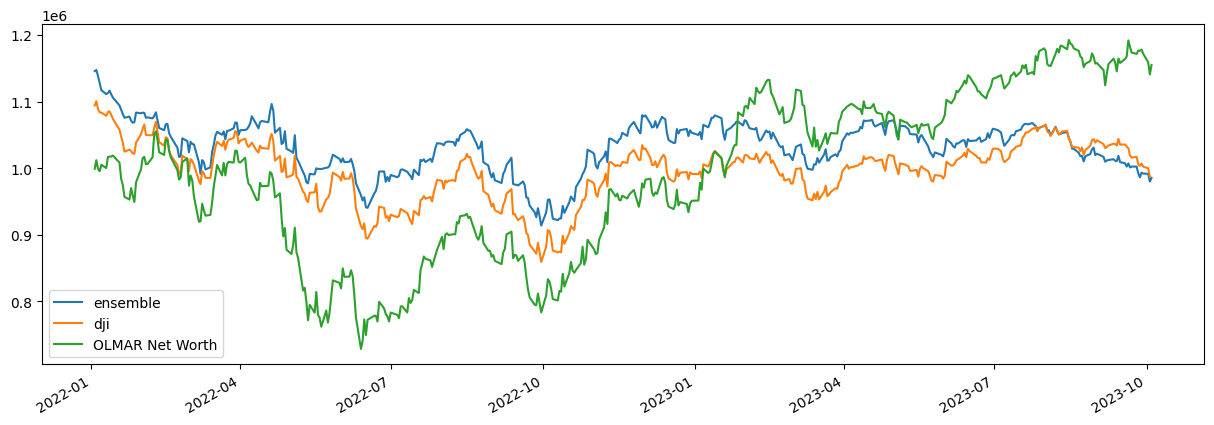

In [10]:
result = pd.DataFrame()

df = pd.DataFrame(net_worth)

print(df)

# Combine the DataFrames side-by-side
combined_df = pd.concat([X.Date, df], axis=1)

combined_df.columns = ["Date", "OLMAR Net Worth"]
print(combined_df)

combined_df.set_index('Date', inplace=True)

# TODO Change result period to use saved file
result = pd.read_csv(ensemble_results_file)

result.set_index('date', inplace=True)

result.index = pd.to_datetime(result.index)

print(result)

# Join DataFrames on date index
merged_df = result.join(combined_df, how='inner')
print(merged_df)


%matplotlib inline
plt.rcParams["figure.figsize"] = (15,5)
plt.figure();
merged_df.plot();

[*********************100%***********************]  1 of 1 completed

==============Get Baseline Stats===========
Shape of DataFrame:  (688, 8)
Annual return          0.054722
Cumulative returns     0.156565
Annual volatility      0.149155
Sharpe ratio           0.432290
Calmar ratio           0.249406
Stability              0.599802
Max drawdown          -0.219408
Omega ratio            1.076644
Sortino ratio          0.613057
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.036370
Daily value at risk   -0.018536
dtype: float64
Baseline Sharpe: -1.2572292345322313
==============Get Backtest Stats===========
Annual return          0.241138
Cumulative returns     0.805161
Annual volatility      0.234994
Sharpe ratio           1.038144
Calmar ratio           0.778411
Stability              0.842242
Max drawdown          -0.309782
Omega ratio            1.196020
Sortino ratio          1.564582
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.082335
Daily value at risk   -0.02863


C:\Users\bencj\AppData\Local\Temp\ipykernel_6104\1934935889.py:25: DeprecationWarning: Risk functions in pyfolio.timeseries are deprecated and will be removed in a future release. Please install the empyrical package instead.
  sharpe = timeseries.sharpe_ratio(daily_ret, risk_free= 0.001)
C:\Users\bencj\AppData\Local\Temp\ipykernel_6104\1934935889.py:40: DeprecationWarning: Risk functions in pyfolio.timeseries are deprecated and will be removed in a future release. Please install the empyrical package instead.
  sharpe = timeseries.sharpe_ratio(daily_ret, risk_free= 0.001)


<Figure size 1500x500 with 0 Axes>

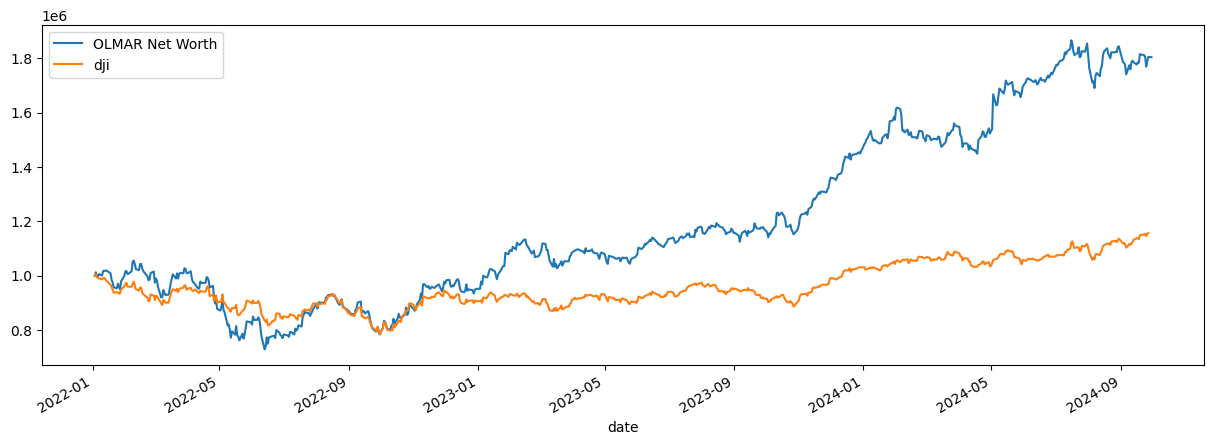

In [11]:
from finrl.plot import backtest_stats,  get_baseline, get_daily_return
from pyfolio import timeseries

first_date = combined_df.index.min()
last_date = combined_df.index.max()


print("==============Get Baseline Stats===========")
df_dji_ = get_baseline(
        ticker="^DJI",
        start = first_date,
        end = last_date)

stats = backtest_stats(df_dji_, value_col_name = 'close')


df_dji = pd.DataFrame()
df_dji['date'] = combined_df.index
df_dji['dji'] = df_dji_['close'] / df_dji_['close'][0] * initial_cash
df_dji = df_dji.set_index(df_dji.columns[0])


daily_ret = get_daily_return(df_dji_, value_col_name = 'close')
# TODO use the correct rf rate
sharpe = timeseries.sharpe_ratio(daily_ret, risk_free= 0.001)
print("Baseline Sharpe:", sharpe)


combined_df = pd.DataFrame({'date': combined_df.index, 'OLMAR Net Worth': combined_df['OLMAR Net Worth']})
combined_df = combined_df.set_index('date')


print("==============Get Backtest Stats===========")
backtest_df = pd.DataFrame({'date': combined_df.index, 'OLMAR Net Worth': combined_df['OLMAR Net Worth']})
stats = backtest_stats(account_value=backtest_df, value_col_name="OLMAR Net Worth")


daily_ret = get_daily_return(backtest_df, value_col_name="OLMAR Net Worth")
# TODO use the correct rf rate
sharpe = timeseries.sharpe_ratio(daily_ret, risk_free= 0.001)
print("Backtest Sharpe:", sharpe)

print("==============Compare to DJIA===========")
result = pd.DataFrame()

result = pd.merge(combined_df, df_dji, left_index=True, right_index=True)
# print("result: ", result)


%matplotlib inline
plt.rcParams["figure.figsize"] = (15,5)
plt.figure();
result.plot();